## One Week Streaming Predictions with Linear Regression and Random Forest

In this notebook, we predict the number of streams songs will have in one week using two models: linear regression and a random forest. At the end, we compare the results of the two models. We use the following features:

**day_N**: the number of streams lagged by N days (day_0 = today, day_1 = yesterday, etc.)

**popularity**: a song's spotify popularity score

**days_since_release**: number of days since a song's release

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, SCORERS
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso
import joblib

pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_rows', 100)

In [2]:
data = pd.read_csv('../csv_files/snowflake_data.csv')
data.rename(columns={'target': 'Next Full Week Streams'}, inplace=True)
data

,artist,title,unified_song_id,date,release_date,this_day,this_week,days_since_release,day_of_week,rn,end_of_week,popularity,day_0,day_1,day_2,day_3,day_4,day_5,day_6,Next Full Week Streams
0,Young Thug,Hercules,100070,2024-07-11,2016-02-05,15504,104046.00,3079,6,1,True,51,15504,15224.00,15367.00,14891.00,13279.00,14595.00,13974.00,100669
1,Young Thug,Hercules,100070,2024-07-04,2016-02-05,14410,104344.00,3072,6,1,True,51,14410,16173.00,15372.00,14658.00,12695.00,14821.00,15917.00,102646
2,Young Thug,Hercules,100070,2024-06-27,2016-02-05,15979,100850.00,3065,6,1,True,51,15979,15387.00,15061.00,14665.00,12847.00,14473.00,15932.00,103858
3,Young Thug,Hercules,100070,2024-06-20,2016-02-05,15343,103313.00,3058,6,1,True,51,15343,14816.00,14320.00,13438.00,12405.00,14523.00,16005.00,104343
4,Young Thug,Hercules,100070,2024-06-13,2016-02-05,15999,101589.00,3051,6,1,True,51,15999,15412.00,15053.00,13938.00,12305.00,14530.00,16076.00,100850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232615,Kylie Minogue,My Oh My (With Bebe Rexha & To,245207279,2024-07-11,2024-07-11,125551,0.00,0,6,1,True,67,125551,NaN,NaN,NaN,NaN,NaN,NaN,894109
232616,Tiesto & Lucas & Steve,ZENLESS,245214101,2024-07-11,2024-07-02,45169,61607.00,9,6,1,True,53,45169,47136.00,50775.00,62879.00,50048.00,59943.00,74695.00,195923
232617,Tiesto & Lucas & Steve,ZENLESS,245214101,2024-07-04,2024-07-02,27206,NaN,2,6,1,True,53,27206,15107.00,19281.00,NaN,NaN,NaN,NaN,389998
232618,Bizzy Banks,Back In The Mix,245773621,2024-07-11,2024-07-11,1238,NaN,0,6,1,True,35,1238,NaN,NaN,NaN,NaN,NaN,NaN,58350


## Data Cleansing

First, let's check if we have any duplicates (we shouldn't since the query should handle that). 

In the output below, we can see that there is some weird stuff going on with the 0 values. The number of streams jumps from a very high value to a very low value, and then to 0. For example, row 386 jumps from 51743 streams on day_3, to 5 streams on day_4, to 0 streams on day_5. Thus, we can essentially treat the zeros as null values. This will allow us to perform interpolation on these null values later on.

In [3]:
pd.set_option('display.max_rows', 100)

days = ['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6']
keep_cols = ['popularity', 'days_since_release', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'Next Full Week Streams']


duplicates = data[data.duplicated(['unified_song_id', 'date', 'release_date'], keep=False)]
print("Number of duplicates: ", len(duplicates))

dropped = data.drop(columns=['this_week'], axis=1)

# Shows all rows where there is a 0 in any of the columns in 'days'
dropped[(dropped[days] == 0).any(axis=1)][keep_cols].head(10)

Number of duplicates:  0


,popularity,days_since_release,day_0,day_1,day_2,day_3,day_4,day_5,day_6,Next Full Week Streams
105296,23,4766,0,0.00,0.00,0.00,0.00,NaN,NaN,0
211395,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0
226747,12,1,1387,0.00,NaN,NaN,NaN,NaN,NaN,41299
226803,0,7,7,0.00,0.00,0.00,0.00,0.00,0.00,38393
227596,5,1,1679,0.00,NaN,NaN,NaN,NaN,NaN,77159
228309,10,147,2,0.00,0.00,0.00,0.00,0.00,0.00,119728
228310,10,140,0,0.00,0.00,0.00,0.00,NaN,NaN,2
228408,8,147,2,0.00,0.00,0.00,0.00,0.00,0.00,230162
228409,8,140,0,0.00,0.00,0.00,0.00,NaN,NaN,2
228494,55,63,1004,955.00,1012.00,664.00,117.00,0.00,0.00,36473


In [4]:
data = data[keep_cols]


train_valid, test = train_test_split(data, test_size = 0.15, random_state = 42)
train, valid = train_test_split(train_valid, test_size = 0.15, random_state = 42)

train.to_csv('../csv_files/train.csv', index=False)
valid.to_csv('../csv_files/valid.csv', index=False)
test.to_csv('../csv_files/test.csv', index=False)

In [5]:
train[(train[days] == 0).all(axis=1)]

,popularity,days_since_release,day_0,day_1,day_2,day_3,day_4,day_5,day_6,Next Full Week Streams
231822,40,50,0,0.00,0.00,0.00,0.00,0.00,0.00,15246
232501,76,34,0,0.00,0.00,0.00,0.00,0.00,0.00,39893
232269,53,82,0,0.00,0.00,0.00,0.00,0.00,0.00,33936


In [6]:
train[train['popularity'] == 0]

,popularity,days_since_release,day_0,day_1,day_2,day_3,day_4,day_5,day_6,Next Full Week Streams
134045,0,1247,1728,1661.00,1694.00,1487.00,1565.00,1793.00,2207.00,11508
46355,0,4234,31140,31146.00,29509.00,27781.00,26986.00,31112.00,31760.00,203493
125317,0,1541,2514,2546.00,2473.00,2299.00,2047.00,2405.00,2618.00,18467
189567,0,461,4283,4271.00,3901.00,3950.00,3308.00,3535.00,4097.00,25407
86919,0,2295,89386,114776.00,118785.00,114277.00,104100.00,109149.00,113566.00,758818
...,...,...,...,...,...,...,...,...,...,...
41736,0,3229,10883,10527.00,10147.00,9966.00,7614.00,9345.00,11494.00,70505
88814,0,2080,5273,5199.00,4664.00,4332.00,3858.00,4742.00,5299.00,35201
98473,0,2003,2137,2256.00,2123.00,2232.00,2051.00,2094.00,2557.00,13284
133269,0,1441,2482,2345.00,2338.00,2172.00,1918.00,2103.00,2063.00,15937


Let's really try to pick apart the data in each of these columns. If we take a closer look at the 'popularity' column, we see that there are tons of songs that have a popularity score of 0, despite having streaming trends that would indicate a higher popularity score. For example, row item 75632 got over 150,000 streams on most days, but has a popularity score of 0. Let's fix this by replacing all of the zeros with the mean of the 'popularity' column.

In [7]:
def interpolate_vals(data, cols):
    copy = data.copy()
    
    # Replace all zeros with nulls
    copy[cols] = copy[cols].replace(0, np.nan)
        
    # Interpolate missing values based on previous values
    copy[cols] = copy[cols].interpolate(method='linear', axis=1)
    
    # Backwards fill missing values that have no previous values 
    # this happens if day_0 has a missing value, for example
    copy[cols] = copy[cols].interpolate(method='bfill', axis=1)
    
    # Replace the remaining null values with ones so that we can apply log transformations later
    # This will effectively replace ones into the rows that were previously filled with zeros
    copy[cols] = copy[cols].replace(np.nan, 1)
    copy['Next Full Week Streams'] = copy['Next Full Week Streams'].replace(0, 1)
    
    # Replace popularity scores of 0 with the mean
    pop_mean = np.mean(copy['popularity'])
    copy['popularity'] = copy['popularity'].replace(0, pop_mean)

    return copy


print("Before imputing the popularity mean:")
print(train.loc[75632]) 
print("\n")
train_filled = interpolate_vals(train, days)
print("After imputing the popularity mean :")
print(train_filled.loc[8357])

Before imputing the popularity mean:
popularity                     0.00
days_since_release          4972.00
day_0                     172855.00
day_1                     167642.00
day_2                     162830.00
day_3                     155969.00
day_4                     148634.00
day_5                     163679.00
day_6                     171865.00
Next Full Week Streams   1194139.00
Name: 75632, dtype: float64


After imputing the popularity mean :
popularity                  38.00
days_since_release        3999.00
day_0                     4952.00
day_1                     4941.00
day_2                     4988.00
day_3                     4740.00
day_4                     3644.00
day_5                     4466.00
day_6                     5310.00
Next Full Week Streams   31326.00
Name: 8357, dtype: float64


In [8]:
def log_transform(data, *cols, prediction_col):
    copy = data.copy()
    for col in cols:
        # These two columns have several zeros, so we increment each by 1 to get rid of them
        if col == 'days_since_release' or col == prediction_col:
            copy[col] = np.ones(len(copy)) + copy[col]
        copy[col] = np.log(copy[col])
        copy.rename(columns={col: "log " + col}, inplace=True)
    return copy[[c for c in copy if c != ('log ' + prediction_col)] + ['log ' + prediction_col]]


In [9]:
def add_pct_change(data):
    data.loc[:, '1_day_%_change'] = ((data['day_0'] - data['day_1']) / data['day_1']) * 100
    data.loc[:, '3_day_%_change'] = ((data['day_0'] - data['day_3']) / data['day_3']) * 100
    data.loc[:, '6_day_%_change'] = ((data['day_0'] - data['day_6']) / data['day_6']) * 100
    return data


## Exploratory Data Analysis (EDA) and Feature Engineering

Now, let's look at the distributions of each of our features. We can see that the distributions for the target, days_since_release, and each of the day_N columns are very skewed right (Note: only the day_0 distribution is included, though the remaining day_N columns follow a similar distribution). 

Since these features have irregular distributions, we can use feature engineering to help normalize the distributions. Namely, log transformations will be our friend. Let's see if there are any other features that will help improve our model.

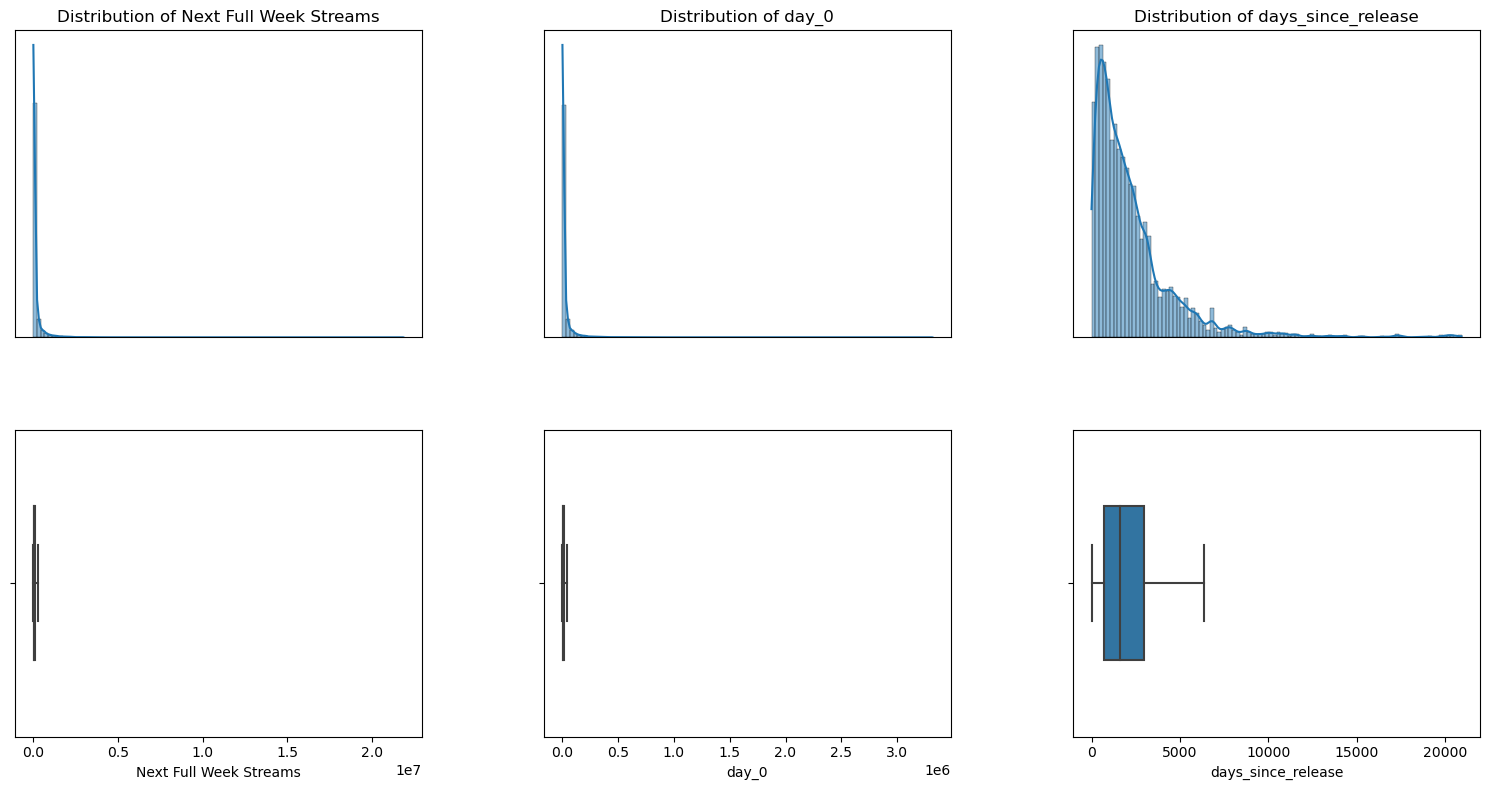

<Figure size 640x480 with 0 Axes>

In [10]:
def plot_distribution(data, *labels):
    num_cols = len(labels)
    fig, axs = plt.subplots(nrows=2, ncols=num_cols, figsize=(15, 8))  # Adjust figsize as needed

    for idx, label in enumerate(labels):
        # Plot histogram using sns.histplot
        sns.histplot(data=data[label], kde=True, ax=axs[0, idx], bins=100)
        axs[0, idx].set_title('Distribution of ' + label)
        axs[0, idx].set_xlabel(label)
        axs[0, idx].set_ylabel('Density')

        # Plot boxplot using sns.boxplot
        sns.boxplot(x=data[label], ax=axs[1, idx], width=0.5, showfliers=False)
        axs[1, idx].set_xlabel(label)
        axs[1, idx].set_ylabel('')

        # Adjust xlim for better visualization
        spacer = np.ptp(data[label]) * 0.05  # 5% of the peak-to-peak range
        xmin = np.min(data[label]) - spacer
        xmax = np.max(data[label]) + spacer
        axs[0, idx].set_xlim(xmin, xmax)
        axs[1, idx].set_xlim(xmin, xmax)

        # Remove some axis text
        axs[0, idx].xaxis.set_visible(False)
        axs[0, idx].yaxis.set_visible(False)

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    plt.show()
    
plot_distribution(train_filled, 'Next Full Week Streams', 'day_0', 'days_since_release')
plt.show()
plt.tight_layout()

In [11]:
train_log = log_transform(
    train_filled, 
    'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'days_since_release', 'Next Full Week Streams',
    prediction_col='Next Full Week Streams'
)
train_log


,popularity,log days_since_release,log day_0,log day_1,log day_2,log day_3,log day_4,log day_5,log day_6,log Next Full Week Streams
16978,57.00,9.21,10.20,10.19,10.15,10.04,9.80,10.04,10.17,12.07
122639,43.00,7.34,9.50,9.48,9.49,9.43,9.26,9.36,9.53,11.36
226919,55.00,4.43,10.66,10.69,10.68,10.71,10.49,10.64,10.88,12.56
196537,56.00,6.24,11.01,11.00,10.96,10.98,10.73,10.82,11.03,12.89
45157,18.00,8.87,7.78,7.84,7.79,7.79,7.70,7.86,7.91,9.72
...,...,...,...,...,...,...,...,...,...,...
3874,43.00,9.43,9.78,9.71,9.56,9.50,9.40,9.57,9.68,11.61
131844,63.00,7.24,11.06,11.04,10.97,10.90,10.79,11.02,11.02,12.93
68605,31.00,8.28,8.17,8.16,8.16,8.14,8.02,8.17,8.26,10.10
13612,26.00,8.63,7.23,7.26,7.24,7.13,7.06,7.21,7.38,9.14


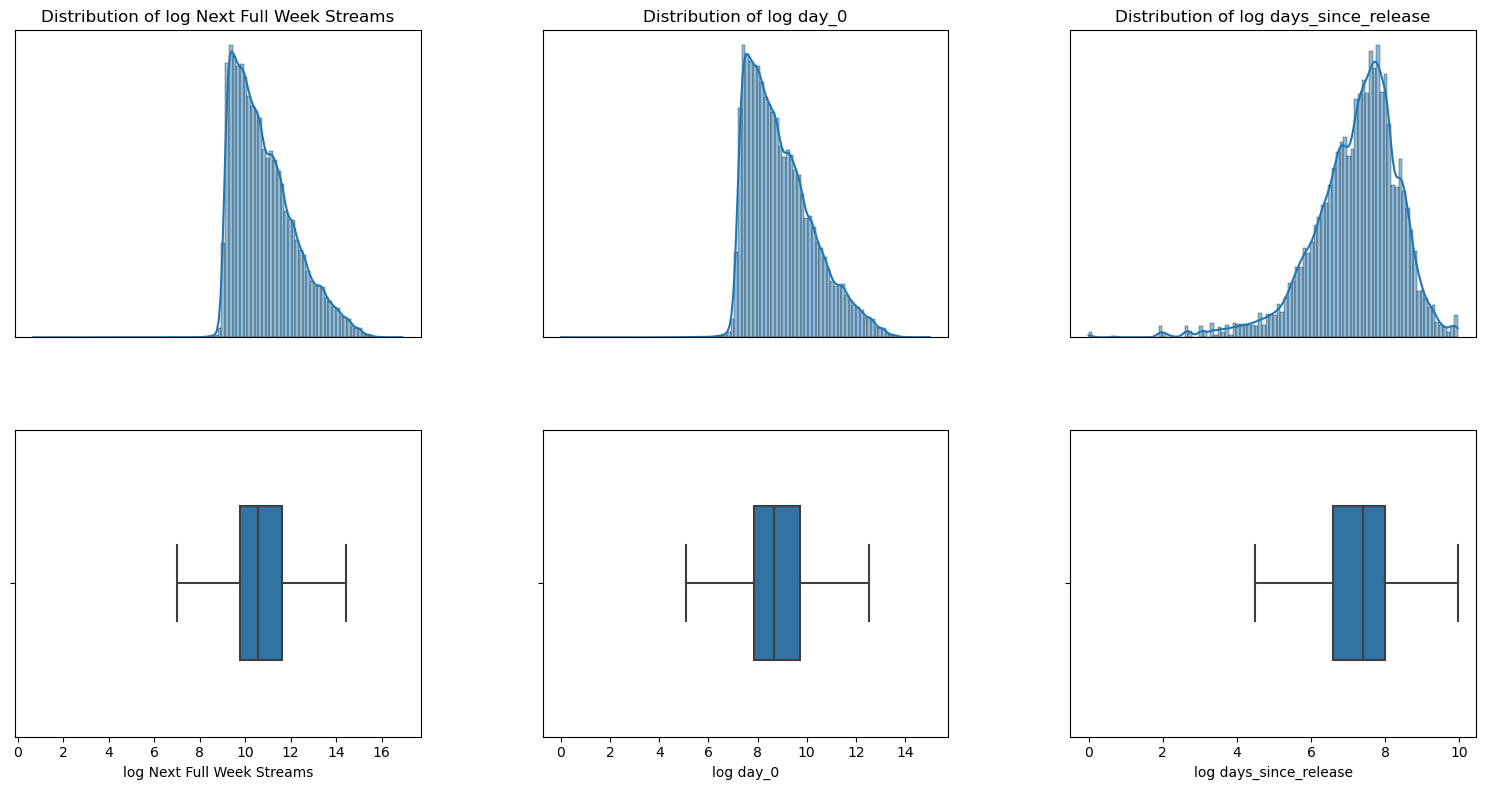

<Figure size 640x480 with 0 Axes>

In [12]:
plot_distribution(train_log, 'log Next Full Week Streams', 'log day_0', 'log days_since_release')
plt.show()
plt.tight_layout()

#### So much better!

Now that we have defined all of our data processing functions, let's create a pipeline function. Instead of having to pass our DataFrame into several functions that apply transformations, add features, and fill values, the pipeline function will allow us to combine all of these operations into one function.

In [13]:
def feature_engine_pipe(data, pipeline_functions, prediction_col):
    """Process the data for a guided model."""
    for function, arguments, keyword_arguments in pipeline_functions:
        if keyword_arguments and (not arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (arguments):
            data = data.pipe(function, *arguments)
        elif keyword_arguments and arguments:
            data = data.pipe(function, *arguments, **keyword_arguments)
        else:
            data = data.pipe(function)
    X = data.drop(columns=[prediction_col])
    Y = data.loc[:, prediction_col]
    return X, Y

In [14]:
days = ['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6']

# Helper function
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

# Pipelines, a list of tuples
train_pipelines = [
    (interpolate_vals, None, {
        'cols': days,
    }),  
    (add_pct_change, None, None),
    (log_transform, 
        ['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'days_since_release', 'Next Full Week Streams'], 
        {'prediction_col': 'Next Full Week Streams'}
    )
]

valid_pipelines = [
    (interpolate_vals, None, {
        'cols': days,
    }),  
    (add_pct_change, None, None),
        (log_transform, 
        ['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'days_since_release', 'Next Full Week Streams'], 
        {'prediction_col': 'Next Full Week Streams'}
    )
]

X_train, Y_train = feature_engine_pipe(train, train_pipelines, 'log Next Full Week Streams')
X_valid, Y_valid = feature_engine_pipe(valid, valid_pipelines, 'log Next Full Week Streams')

# Take a look at the result
# It should be the same above as the result returned by feature_engine_simple
display(X_train.head())
display(Y_train.head())

,popularity,log days_since_release,log day_0,log day_1,log day_2,log day_3,log day_4,log day_5,log day_6,1_day_%_change,3_day_%_change,6_day_%_change
16978,57.00,9.21,10.20,10.19,10.15,10.04,9.80,10.04,10.17,1.15,17.12,3.24
122639,43.00,7.34,9.50,9.48,9.49,9.43,9.26,9.36,9.53,1.29,7.00,-3.58
226919,55.00,4.43,10.66,10.69,10.68,10.71,10.49,10.64,10.88,-2.45,-4.50,-19.57
196537,56.00,6.24,11.01,11.00,10.96,10.98,10.73,10.82,11.03,1.37,3.85,-1.48
45157,18.00,8.87,7.78,7.84,7.79,7.79,7.70,7.86,7.91,-5.70,-0.62,-12.09


16978    12.07
122639   11.36
226919   12.56
196537   12.89
45157     9.72
Name: log Next Full Week Streams, dtype: float64

### Dimensionality Reduction

If we look at the correlation matrix for each of our features below, each of the day_N features are highly correlated with each other. When we construct a model, we want to try to reduce multicollinearity as much as possible, as it can significantly reduce the strength of our model. To mitigate this, we will perform principal component analysis (PCA). At a high level, PCA will transform our data into a lower dimension while attempting to retain as much of the variability in the original dataset as possible. 

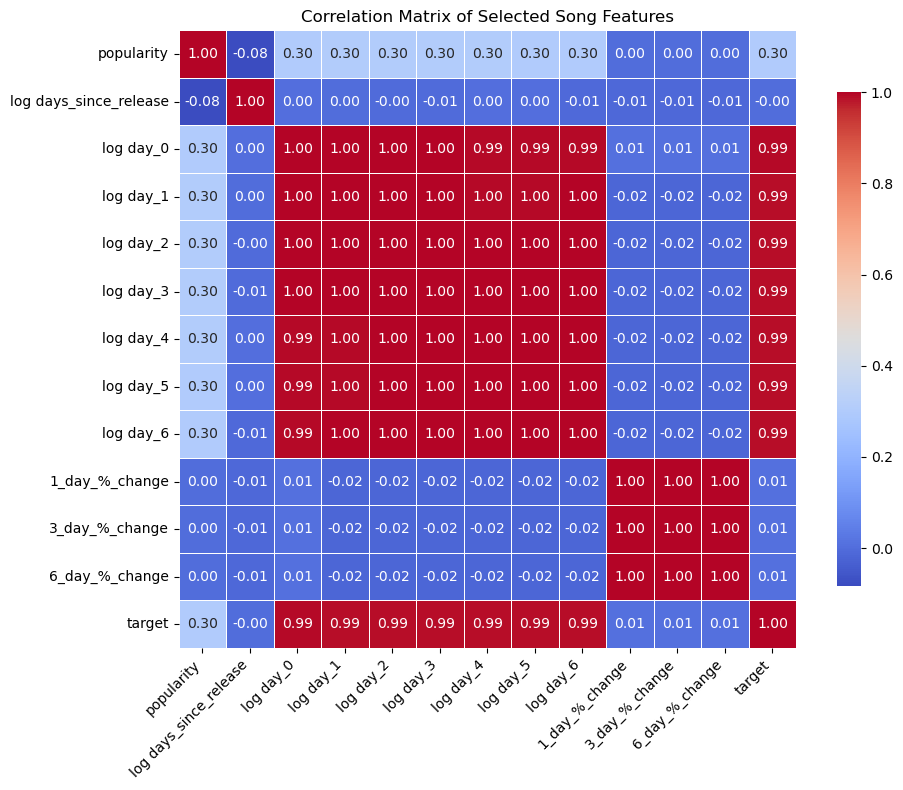

In [15]:
temp = X_train.copy()
temp['target'] = Y_train
correlation_matrix = temp.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Selected Song Features')
plt.xticks(rotation=45, ha='right')  # Rotate feature names for better readability
plt.yticks(rotation=0)
plt.tight_layout()  # Adjust layout to prevent clipping of tick labels
plt.show()

Although we have 12 features in our model, the scree plot below tells us that a majority of the variability in our data is captured by the first two or three principal components. The first PC explains about 0.6, the second 0.25, etc. So, just the first two principal components explain about 85% of the original variability.

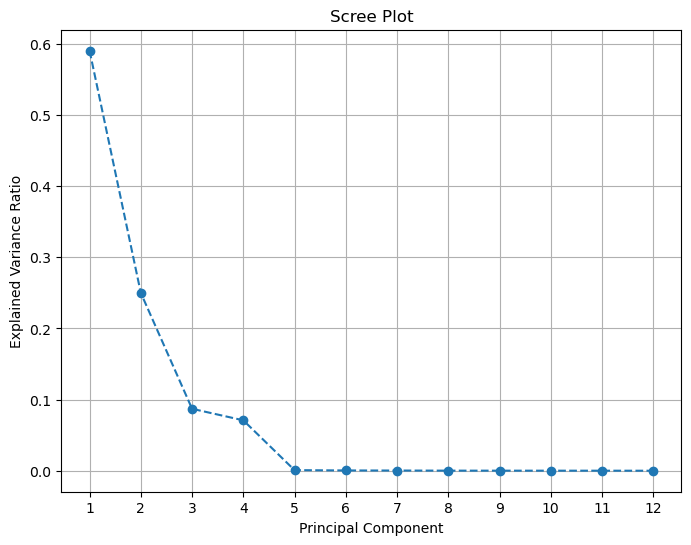

In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

pca = PCA()
pca.fit_transform(X_scaled)

explained_variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.grid(True)
plt.show()

## Building our Models

Finally, what we've all been waiting for! To start, we are going to create Linear Regression models, one that uses L1 regularization (Lasso) and another that uses L2 regularization (Ridge)

In [17]:
def mape(y_true, y_pred):
    """
    Calculate Mean Absolute Percentage Error (MAPE).

    Parameters:
    y_true : array-like of shape (n_samples,)
        Ground truth (correct) target values.
    y_pred : array-like of shape (n_samples,)
        Estimated target values.

    Returns:
    float
        MAPE value.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    # Calculate MAPE
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    return mape

In [18]:
# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()

# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

lr_pipe = Pipeline([
     ("scaler", scaler), 
     ("pca", pca), 
     ("regressor", Lasso())
])

# Parameters of pipelines can be set using '__' separated parameter names:
lr_params = {
    "pca__n_components": [2, 4, 6, 8, 10, 12],
    "regressor": [Ridge(), Lasso()],
    "regressor__fit_intercept": [True, False],
    "regressor__alpha": [0.001, 0.01, 0.1]
}

search = GridSearchCV(lr_pipe, lr_params, cv=10, scoring='neg_mean_absolute_error', n_jobs=-1)
search.fit(X_train, Y_train)

joblib.dump(search, '../models/lr_streampreds.joblib')

/Users/willcoomans/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


['../models/lr_streampreds.joblib']

In [19]:
lr_gdcv = joblib.load('../models/lr_streampreds.joblib')

print("Best parameter (CV score=%0.3e):" % lr_gdcv.best_score_)
print(lr_gdcv.best_params_)

lr = lr_gdcv.best_estimator_

# Predict on the validation set
Y_train_lr = lr.predict(X_train)
Y_valid_lr = lr.predict(X_valid)

# Calculate validation MAPE
train_mape_lr = mape(Y_train, Y_train_lr)
valid_mape_lr = mape(Y_valid, Y_valid_lr)

print("\nLinear Regression Model Log Predictions MAPE:")
print(f"Model Train MAPE: {train_mape_lr:0.3e}")
print(f"Model Valid MAPE: {valid_mape_lr:0.3e}")

Best parameter (CV score=-5.926e-02):
{'pca__n_components': 12, 'regressor': Ridge(alpha=0.1), 'regressor__alpha': 0.1, 'regressor__fit_intercept': True}

Linear Regression Model Log Predictions MAPE:
Model Train MAPE: 5.311e-01
Model Valid MAPE: 5.434e-01


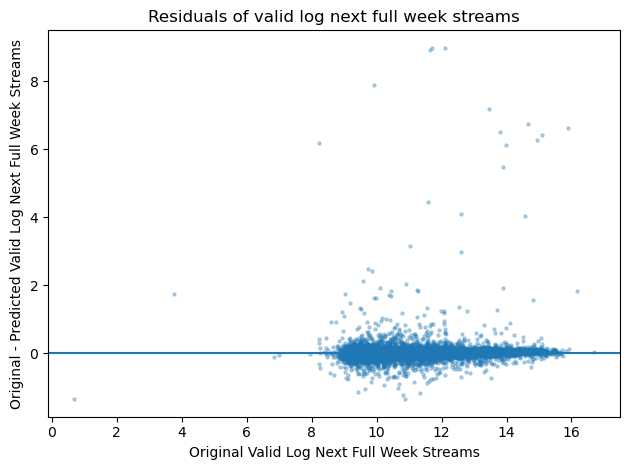

In [20]:
plt.scatter(Y_valid, Y_valid - Y_valid_lr, alpha=0.3, s=5)
plt.axhline(0)
plt.xlabel("Original Valid Log Next Full Week Streams")
plt.ylabel("Original - Predicted Valid Log Next Full Week Streams")
plt.title("Residuals of valid log next full week streams")
plt.tight_layout()

### Linear Regression Model Evaluation

Above, we can see the residual plot of next full week streams. There appears to be no pattern between the residuals and the original target values, which indicates that our linear model is a good fit. Now, we will reverse the log transformations on the target and predicted values, so we can better interpret our results. 

To understand how well our model is performing, we will compare the root mean squared error (RMSE) of our model with the RMSE of a naive model. The naive model simply predicts the sum of the day_N columns.

In [24]:
X_test, Y_test = feature_engine_pipe(test, valid_pipelines, 'log Next Full Week Streams')
test_filled = interpolate_vals(test, days)

Y_test_lr = lr.predict(X_test)

naive_preds = test_filled['day_0'] + test_filled['day_1'] + test_filled['day_2'] + test_filled['day_3'] + test_filled['day_4'] + test_filled['day_5'] + test_filled['day_6'] 
lr_preds_df = pd.DataFrame({'True Log Next Full Week Streams' : Y_test, 
                         'Predicted Log Next Full Week Streams' : Y_test_lr, 
                         'True Next Full Week Streams' : np.e**Y_test, 
                         'Predicted Next Full Week Streams' : np.e**Y_test_lr,
                         'Naive Next Full Week Streams': naive_preds}
                       )

lr_preds_df.iloc[:, 3] = lr_preds_df.iloc[:, 3].apply(lambda x: f"{x:.2f}").astype(float)

lr_preds_df.head(5)


,True Log Next Full Week Streams,Predicted Log Next Full Week Streams,True Next Full Week Streams,Predicted Next Full Week Streams,Naive Next Full Week Streams
183428,13.62,13.55,820906.00,765930.89,804143.00
127327,10.63,10.61,41300.00,40594.79,41181.00
55853,10.52,10.55,36994.00,38318.41,35707.00
17074,14.47,14.43,1931238.00,1841602.48,1893785.00
71517,12.01,11.97,164942.00,158109.43,160223.00


In [49]:
true_test = lr_preds_df['True Next Full Week Streams']
pred_test = lr_preds_df['Predicted Next Full Week Streams']

model_test_mae = mean_squared_error(true_test, pred_test)
model_test_r2 = r2_score(true_test, pred_test)

baseline_mae = mean_squared_error(true_test, naive_preds)
baseline_r2 = r2_score(true_test, naive_preds)

print(f"Model Test MAE: {model_test_mae:0.3e}")
print(f"Model Test R-Squared Score: {model_test_r2} \n")
print(f"Baseline MAE: {baseline_mae:0.3e}")
print(f"Baseline R-Squared Score: {baseline_r2}")


Model Test MAE: 1.381e+10
Model Test R-Squared Score: 0.9455772413006979 

Baseline MAE: 1.205e+10
Baseline R-Squared Score: 0.9525223016699379


### Random Forest Regressor

Our previous model looks pretty good! Let's see if we can do better using the random forest regressor, which leverages an ensemble of decision trees. 

In [ ]:
# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()

# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

rf_pipe = Pipeline([
    ("scaler", scaler),
    ("pca", pca),
    ("regressor", RandomForestRegressor())
])

# Parameters of pipelines can be set using '__' separated parameter names:
rf_params = {
    "pca__n_components": [2, 4, 6, 8, 10],
    "regressor__n_estimators": [150, 200, 250],
    "regressor__max_depth": [None, 30, 40],
    "regressor__min_samples_split": [2, 4, 10],
    "regressor__min_samples_leaf": [1, 2, 4],
    "regressor__max_features": ["sqrt", "log2", None]
}
     
rfr_search = RandomizedSearchCV(rf_pipe, rf_params, cv=5, n_iter=50, scoring='neg_mean_absolute_error', n_jobs=-1)
rfr_search.fit(X_train, Y_train)

joblib.dump(rfr_search, '../models/rfr_streampreds.joblib')

/Users/willcoomans/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Here, we save our various random forest regressors found using RandomizedSearchCV with joblib so that we don't have to retrain them everytime we open the notebook.

In [21]:
rfr_rscv = joblib.load('../models/rfr_streampreds.joblib')

print("Best parameters (CV score=%0.3e):" % rfr_rscv.best_score_)
print("\n")
print(rfr_rscv.best_params_)

rfr = rfr_rscv.best_estimator_

Best parameters (CV score=-1.394e-02):


{'regressor__n_estimators': 150, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 'log2', 'regressor__max_depth': 40, 'pca__n_components': 10}


In [22]:
# Predict on the validation set
Y_train_rfr = rfr.predict(X_train)
Y_valid_rfr = rfr.predict(X_valid)

# Calculate validation MAPE
train_mape_rfr = mape(Y_train, Y_train_rfr)
valid_mape_rfr = mape(Y_valid, Y_valid_rfr)

print("\nRandom Forest Regressor Log Predictions MAPE:")
print(f"Model Train MAPE: {train_mape_rfr:0.3e}")
print(f"Model Valid MAPE: {valid_mape_rfr:0.3e}")


Random Forest Regressor Log Predictions MAPE:
Model Train MAPE: 1.891e-01
Model Valid MAPE: 5.182e-01


In [25]:
# Predict on the testing set
Y_test_rfr = rfr.predict(X_test)


all_preds = pd.DataFrame({
    "True Log Next Full Week Streams": Y_test,
    "LR Predicted Log Next Full Week Streams": Y_test_lr,
    "RFR Predicted Log Next Full Week Streams": Y_test_rfr,
    "True Next Full Week Streams": np.e**Y_test,
    "LR Predicted Next Full Week Streams": np.e**Y_test_lr,
    "RFR Predicted Next Full Week Streams": np.e**Y_test_rfr,
    "Naive Predicted Next Full Week Streams": naive_preds
})

all_preds

,True Log Next Full Week Streams,LR Predicted Log Next Full Week Streams,RFR Predicted Log Next Full Week Streams,True Next Full Week Streams,LR Predicted Next Full Week Streams,RFR Predicted Next Full Week Streams,Naive Predicted Next Full Week Streams
183428,13.62,13.55,13.61,820906.00,765930.89,816195.06,804143.00
127327,10.63,10.61,10.61,41300.00,40594.79,40445.03,41181.00
55853,10.52,10.55,10.51,36994.00,38318.41,36826.37,35707.00
17074,14.47,14.43,14.44,1931238.00,1841602.48,1872732.82,1893785.00
71517,12.01,11.97,11.98,164942.00,158109.43,159726.42,160223.00
...,...,...,...,...,...,...,...
100170,12.85,12.85,12.89,379256.00,380082.87,396358.53,401089.00
208310,9.76,9.76,9.75,17331.00,17401.43,17172.71,17134.00
164510,9.57,9.45,9.43,14368.00,12706.98,12476.35,11713.00
178052,11.23,11.24,11.23,75296.00,76385.46,74989.23,76015.00


In [54]:
true_test = all_preds['True Next Full Week Streams']
lr_test = all_preds['LR Predicted Next Full Week Streams']
rfr_test = all_preds['RFR Predicted Next Full Week Streams']

lr_test_rmse = np.sqrt(mean_squared_error(true_test, lr_test))
lr_test_r2 = r2_score(true_test, lr_test)

rfr_test_rmse = np.sqrt(mean_squared_error(true_test, rfr_test))
rfr_test_r2 = r2_score(true_test, rfr_test)

baseline_rmse = np.sqrt(mean_squared_error(true_test, naive_preds))
baseline_r2 = r2_score(true_test, naive_preds)

print(f"Linear Regression Model Test RMSE: {lr_test_rmse:0.3e}")
print(f"Linear Regression Model Test R-Squared Score: {lr_test_r2} \n")
print(f"Random Forest Regressor Test RMSE: {rfr_test_rmse:0.3e}")
print(f"Random Forest Regressor R-Squared Score: {rfr_test_r2} \n")
print(f"Baseline RMSE: {baseline_rmse:0.3e}")
print(f"Baseline R-Squared Score: {baseline_r2}")

print(100 * abs((lr_test_rmse - baseline_rmse) / baseline_rmse))

Linear Regression Model Test RMSE: 1.175e+05
Linear Regression Model Test R-Squared Score: 0.9455772412745276 

Random Forest Regressor Test RMSE: 1.248e+05
Random Forest Regressor R-Squared Score: 0.9386109454425559 

Baseline RMSE: 1.098e+05
Baseline R-Squared Score: 0.9525223016699379
7.064488873559882


max_depth is how deep a decision tree can go
min_sample_leaf is the minimum # of samples required to split a node

In [36]:
samples = pd.DataFrame({
    "popularity": [81, 73],
    "days_since_release": [41, 196],
    "day_0": [714337, 278341],
    "day_1": [679466, 280059],
    "day_2": [644817, 272030],
    "day_3": [576340, 280325],
    "day_4": [486821, 266206],
    "day_5": [512687, 265174],
    "day_6": [524352, 241347],
    "Next Full Week Streams": [999, 999]
})

X_sample, Y_sample = feature_engine_pipe(samples, valid_pipelines, 'log Next Full Week Streams')
X_sample

,popularity,log days_since_release,log day_0,log day_1,log day_2,log day_3,log day_4,log day_5,log day_6,1_day_%_change,3_day_%_change,6_day_%_change
0,81,3.74,13.48,13.43,13.38,13.26,13.10,13.15,13.17,5.13,23.94,36.23
1,73,5.28,12.54,12.54,12.51,12.54,12.49,12.49,12.39,-0.61,-0.71,15.33


In [37]:
log_preds = lr.predict(X_sample)

In [38]:
print(f'Projected number of streams July 18 - 25 for Apple - Charli xcx: {np.e**log_preds[0]:0.0f}')
print(f'Projected number of streams July 18 - 25 for Happy Hare - Yaelokre: {np.e**log_preds[1]:0.0f}')


Projected number of streams July 18 - 25 for Apple - Charli xcx: 4563628
Projected number of streams July 18 - 25 for Happy Hare - Yaelokre: 1882144
